# Getting Transducer Started

In [14]:
%%capture
! pip install wget

In [15]:
import wget
import os

In [16]:
%%capture
!curl -sS https://apertium.projectjj.com/apt/install-release.sh | sudo bash
!apt install apertium-all-dev lexd

In [17]:
if os.path.exists('ruu.twol'):
  os.remove('ruu.twol')
wget.download('https://raw.githubusercontent.com/PhilBurub/Morphoanalyzer-Ruuli/main/Rules/ruu.twol', 'ruu.twol')
if os.path.exists('ruu.lexd'):
  os.remove('ruu.lexd')
wget.download('https://raw.githubusercontent.com/PhilBurub/Morphoanalyzer-Ruuli/main/Rules/ruu.lexd', 'ruu.lexd')

'ruu.lexd'

In [18]:
!lexd ruu.lexd > ruu-generator.att
!lt-comp rl ruu-generator.att ruu-analyser.bin
!hfst-txt2fst ruu-generator.att -o ruu-deepgenerator.hfst

final@inconditional 1648 2456
main@standard 39969 97159


In [19]:
!hfst-twolc ruu.twol -o ruu.twol.hfst
!lexd ruu.lexd | hfst-txt2fst -o ruu.lexd.hfst
!hfst-compose-intersect ruu.lexd.hfst ruu.twol.hfst -o ruu-generator.hfst

Reading input from ruu.twol.
Writing output to ruu.twol.hfst.
Reading alphabet.
Reading sets.
Reading rules and compiling their contexts and centers.
Compiling rules.
Storing rules.


In [20]:
! hfst-invert ruu-generator.hfst -o ruu-analyzer.hfst

# Testing

In [21]:
import json
import tqdm
from collections import Counter
import re
from matplotlib import pyplot as plt
from matplotlib import font_manager

In [22]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [23]:
def to_plot(counter_dct, label='', limit=None):
  plt.figure(figsize=(50, 20))
  if limit == None:
    limit = len(counter_dct)
  plt.bar([el[0] for el in counter_dct.most_common()][:limit], [el[1] for el in counter_dct.most_common()][:limit], width=1,
        color=[(.17, .18, .42), (.62, .42, .51), 
               (.8, .82, 1), (.76, .50, .55), 
               (.34, .28, .47), (.87, .59, .56)])
  plt.xticks(rotation=90, fontsize=45)
  plt.yticks(fontsize=35)
  plt.xlabel('morphemes', fontsize=50)
  plt.ylabel('num. of errors', fontsize=50)
  plt.title(f'Problematic Morphemes\n{label}', fontsize=55)

In [24]:
if not os.path.exists('gram_tags.json'):
  wget.download('https://raw.githubusercontent.com/PhilBurub/Morphoanalyzer-Ruuli/main/Grammar information/gram_tags.json', 'gram_tags.json')
with open('gram_tags.json', 'r', encoding='utf-8') as tagset:
  gram_tags = json.load(tagset)
gram_tags = set(gram_tags)
pos = {'n', 'v', 'adj', 'adv', 'pro', 'dem', 'intj', 'part', 'prep', 'conj', 'ideo'}

## A Short Pretest

In [25]:
! echo "bukanga" | hfst-lookup ruu-analyzer.hfst

hfst-lookup: warning: It is not possible to perform fast lookups with OpenFST, std arc, tropical semiring format automata.
Using HFST basic transducer format and performing slow lookups
> bukanga	<14><n><roof_apex>	0.000000
bukanga	<14sbj><v><end><fv>	0.000000

> 

In [26]:
! echo "tibakyakolesya" | hfst-lookup ruu-analyzer.hfst

hfst-lookup: warning: It is not possible to perform fast lookups with OpenFST, std arc, tropical semiring format automata.
Using HFST basic transducer format and performing slow lookups
> tibakyakolesya	<neg><2sbj><pers><v><do><caus><fv>	0.000000
tibakyakolesya	<neg><2sbj><pers><v><handle><caus><fv>	0.000000
tibakyakolesya	<neg><2sbj><pers><v><use><fv>	0.000000
tibakyakolesya	<neg><2sbj><pers><v><work><caus><fv>	0.000000

> 

# Big Golden Standard Testing

In [27]:
if not os.path.exists('standard.json'):
  wget.download('https://raw.githubusercontent.com/PhilBurub/Morphoanalyzer-Ruuli/main/Golden Standard/standard.json', 'standard.json')
with open('standard.json', 'r', encoding='utf-8') as std:
  standard = json.load(std)

with open('wrong.txt', 'w', encoding='utf-8') as f:
  pass

In [28]:
valid = 0
err_dct = {'unsupported': Counter(),
          'malanalysed': Counter()}

for wordform in tqdm.tqdm(standard):
  word = '"' + wordform[0] + '"'
  analysis = ! echo {word} | hfst-lookup ruu-analyzer.hfst
  vars = list(map(lambda x: set(re.split(r'><|\.|:', x.split('\t')[1].strip('><'))), analysis[2:-2]))

  if len(vars) == 1 and list(vars[0])[0].endswith('+?'):
    err_dct['unsupported'].update(wordform[1])
    with open('wrong.txt', 'a', encoding='utf-8') as f:
      f.write(f'{word}\tnot supported\t{", ".join(wordform[1])}\n')
    continue

  glosses = set(wordform[1])
  fail = True
  for var in vars:
    drop_pos = var.difference(pos)
    unmatch = glosses.difference(drop_pos)
    if len(unmatch) == 0:
      fail = False
      valid += 1
      break

  if fail == True:
    err_dct['malanalysed'].update(wordform[1])
    with open('wrong.txt', 'a', encoding='utf-8') as f:
      f.write(f'{word}\t{", ".join(wordform[1])}\n')

print(f'\naccuracy={valid/len(standard)}')

100%|██████████| 4896/4896 [22:11<00:00,  3.68it/s]


accuracy=0.315359477124183


## Errors

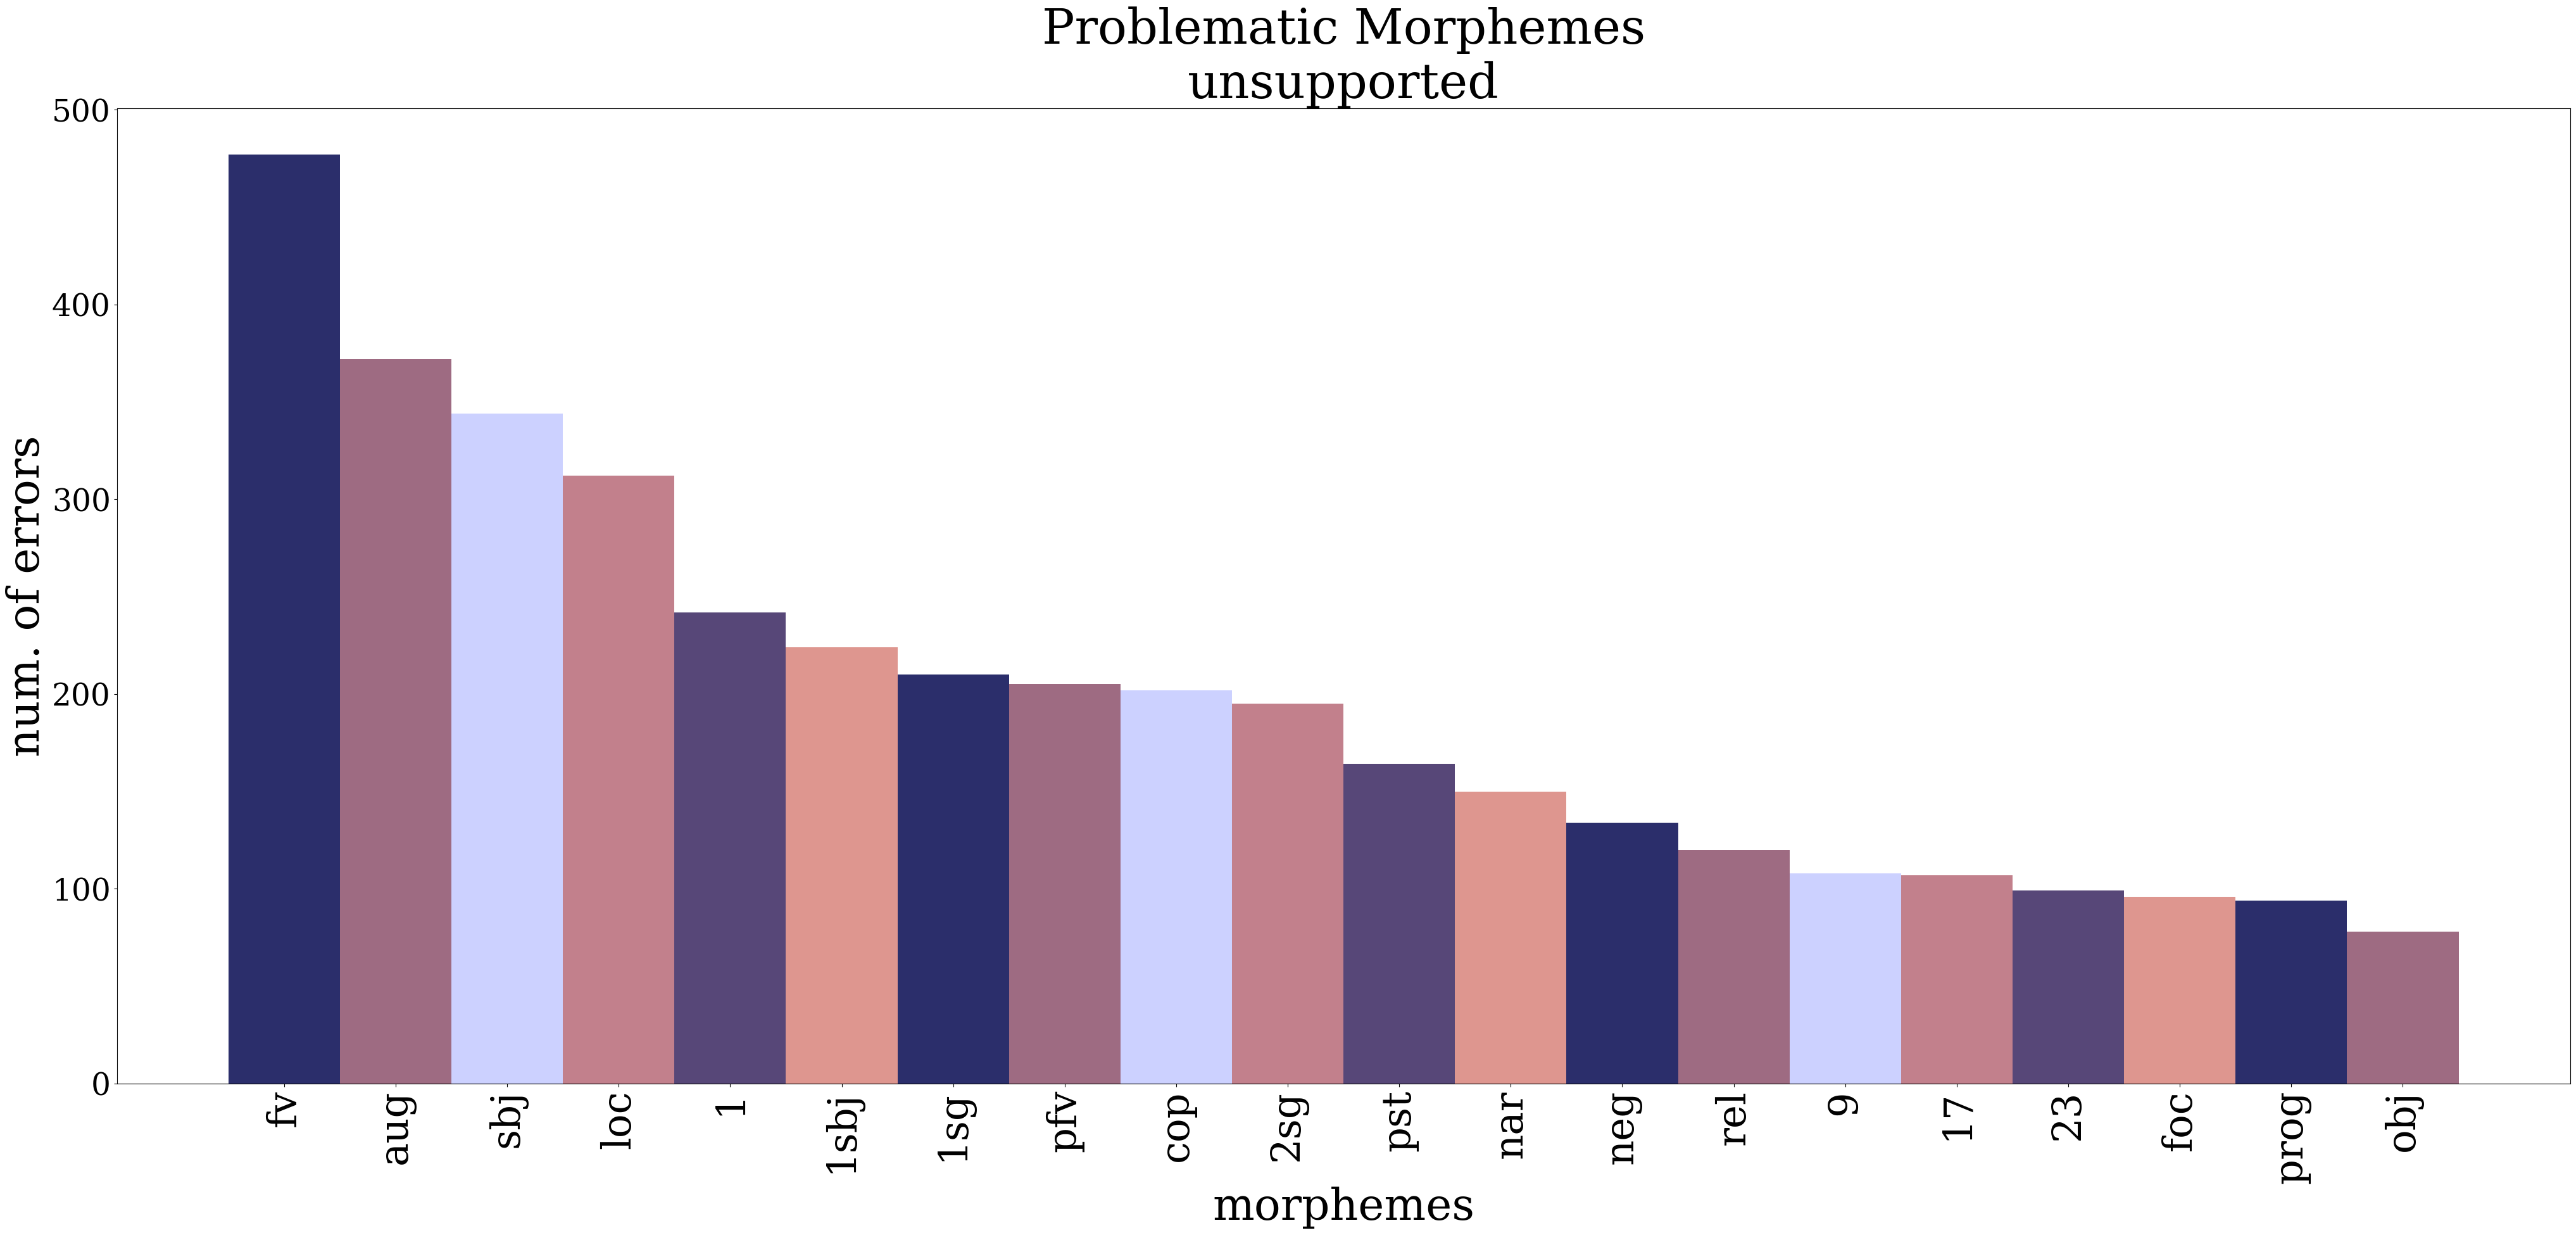

In [29]:
to_plot(err_dct['unsupported'], 'unsupported', limit=20)

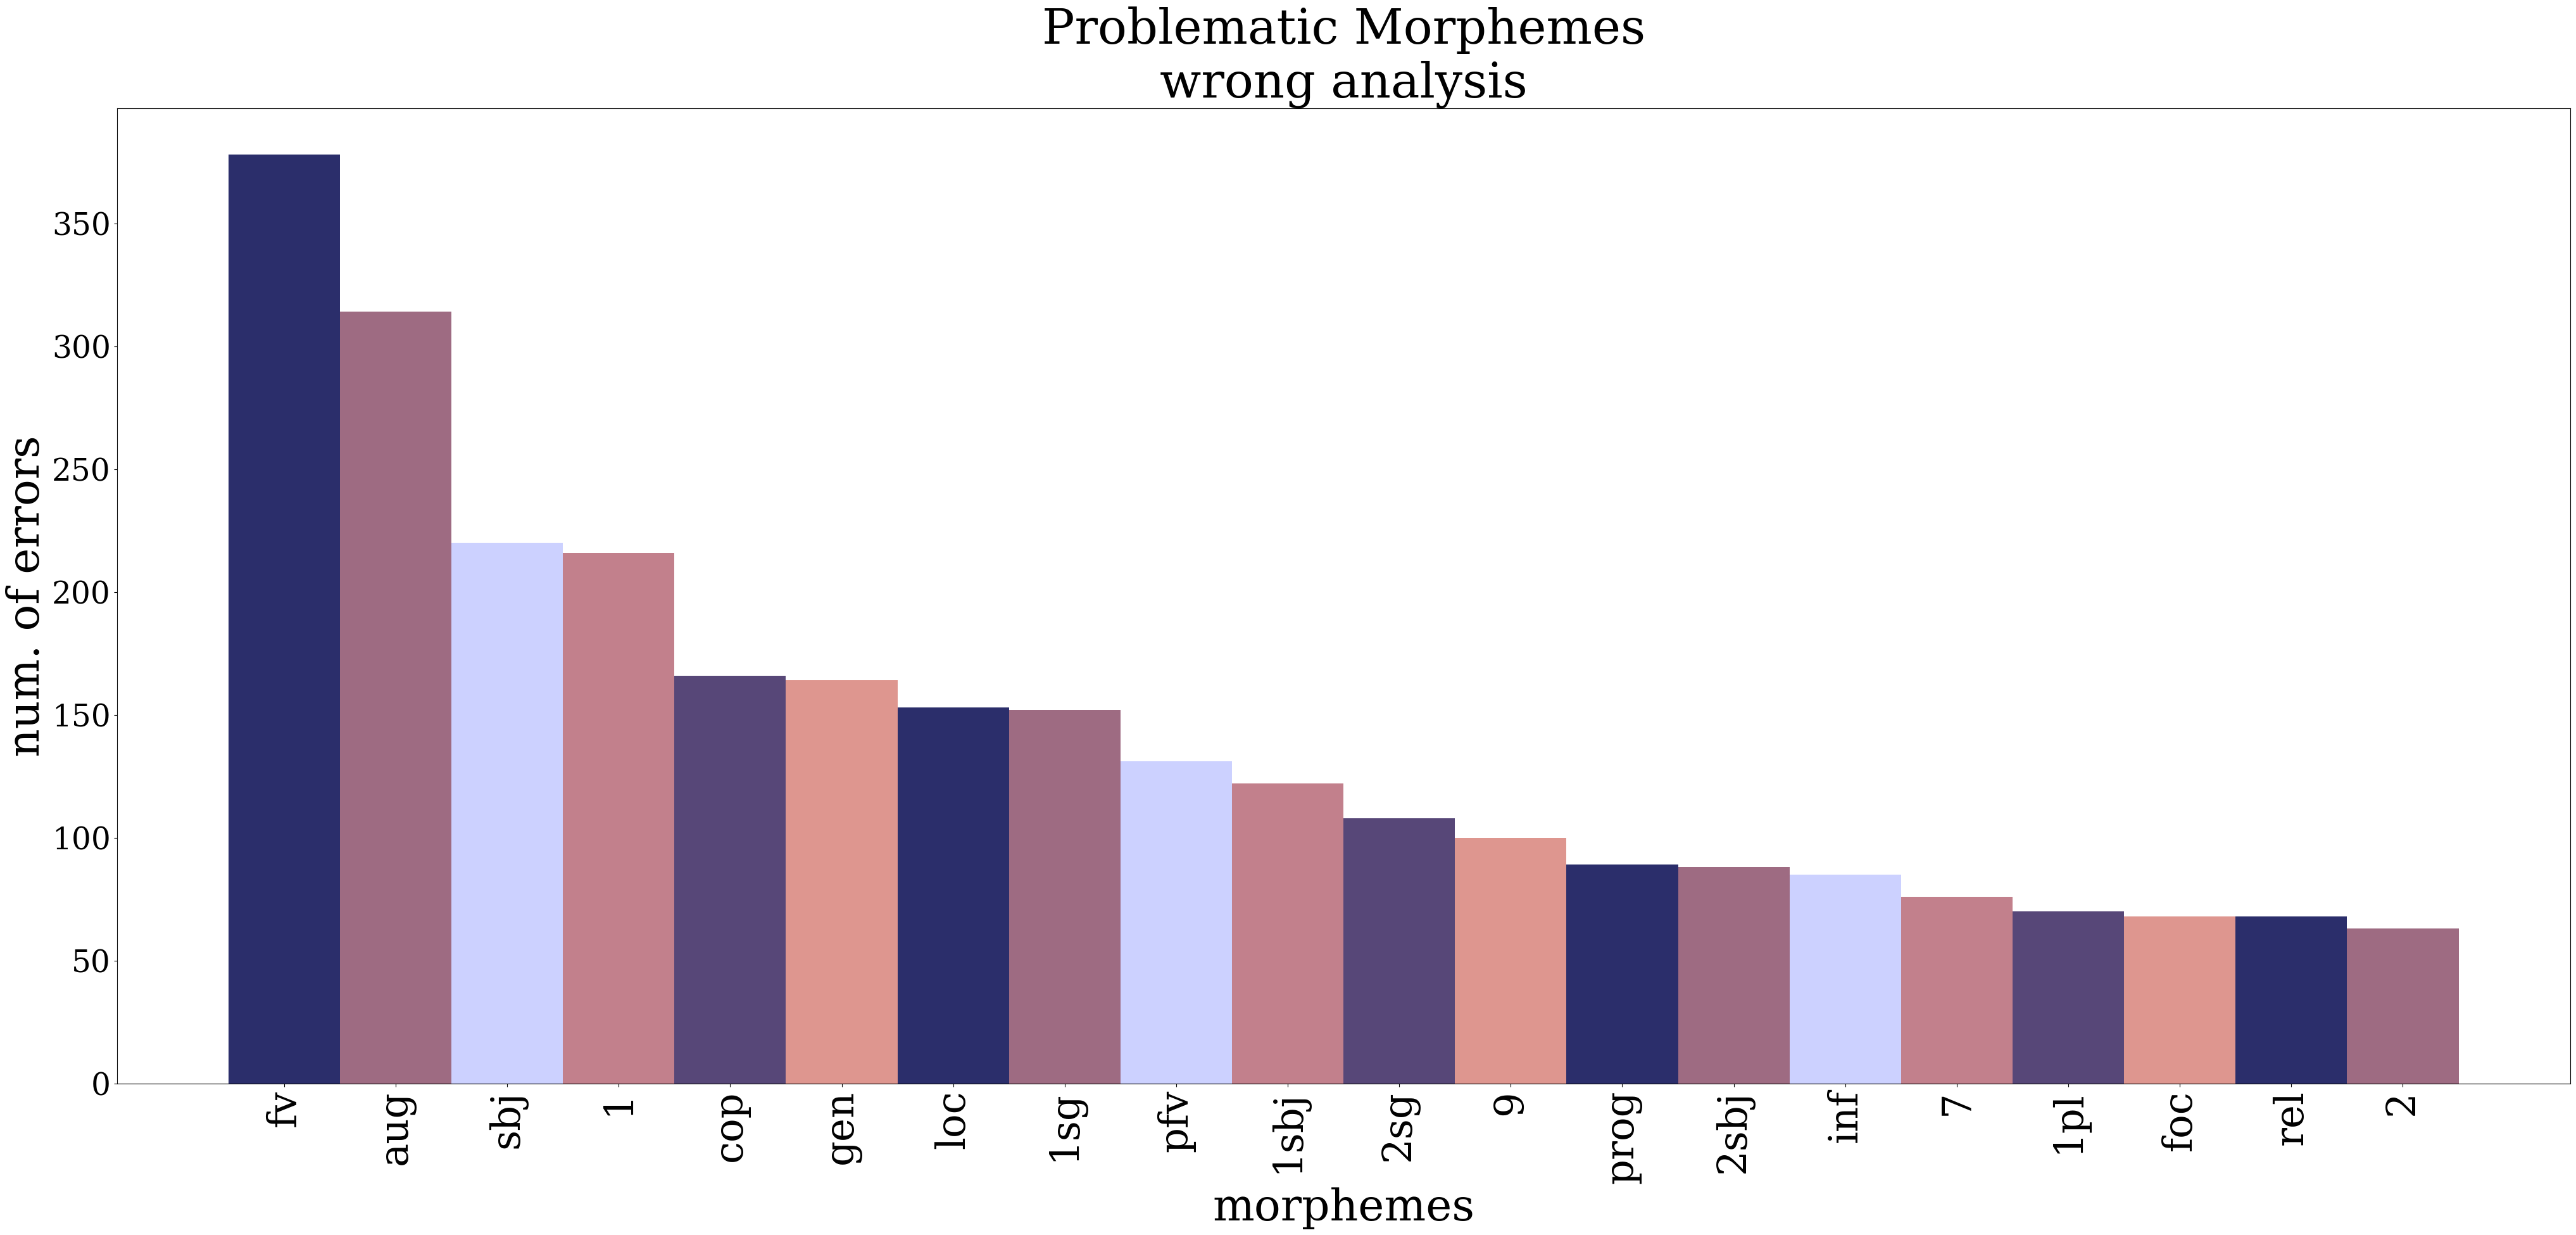

In [30]:
to_plot(err_dct['malanalysed'], 'wrong analysis', limit=20)

# Small Golden Standard Testing

In [31]:
if not os.path.exists('standard_small.json'):
  wget.download('https://raw.githubusercontent.com/PhilBurub/Morphoanalyzer-Ruuli/main/Golden Standard Grammar/standard.json', 'standard_small.json')
with open('standard_small.json', 'r', encoding='utf-8') as std:
  standard = json.load(std)

with open('wrong_small.txt', 'w', encoding='utf-8') as f:
  pass

In [32]:
valid = 0
err_dct = {'unsupported': Counter(),
          'malanalysed': Counter()}

for wordform in tqdm.tqdm(standard):
  word = '"' + wordform[0] + '"'
  analysis = ! echo {word} | hfst-lookup ruu-analyzer.hfst
  vars = list(map(lambda x: set(re.split(r'><|\.|:', x.split('\t')[1].strip('><'))), analysis[2:-2]))

  if len(vars) == 1 and list(vars[0])[0].endswith('+?'):
    err_dct['unsupported'].update(wordform[1])
    with open('wrong_small.txt', 'a', encoding='utf-8') as f:
      f.write(f'{word}\tnot supported\t{", ".join(wordform[1])}\n')
    continue

  glosses = set(wordform[1])
  fail = True
  for var in vars:
    drop_pos = var.difference(pos)
    unmatch = glosses.symmetric_difference(drop_pos)
    if len(unmatch) == 0:
      fail = False
      valid += 1
      break
    if len(unmatch) == 1:
      diff = list(unmatch)[0]
      if diff not in gram_tags:
        fail = False
        valid += 1
        break
  
  if fail == True:
    err_dct['malanalysed'].update(wordform[1])
    with open('wrong_small.txt', 'a', encoding='utf-8') as f:
      f.write(f'{word}\t{", ".join(wordform[1])}\n')

print(f'\naccuracy={valid/len(standard)}')

100%|██████████| 113/113 [00:29<00:00,  3.81it/s]


accuracy=0.7345132743362832


## Errors

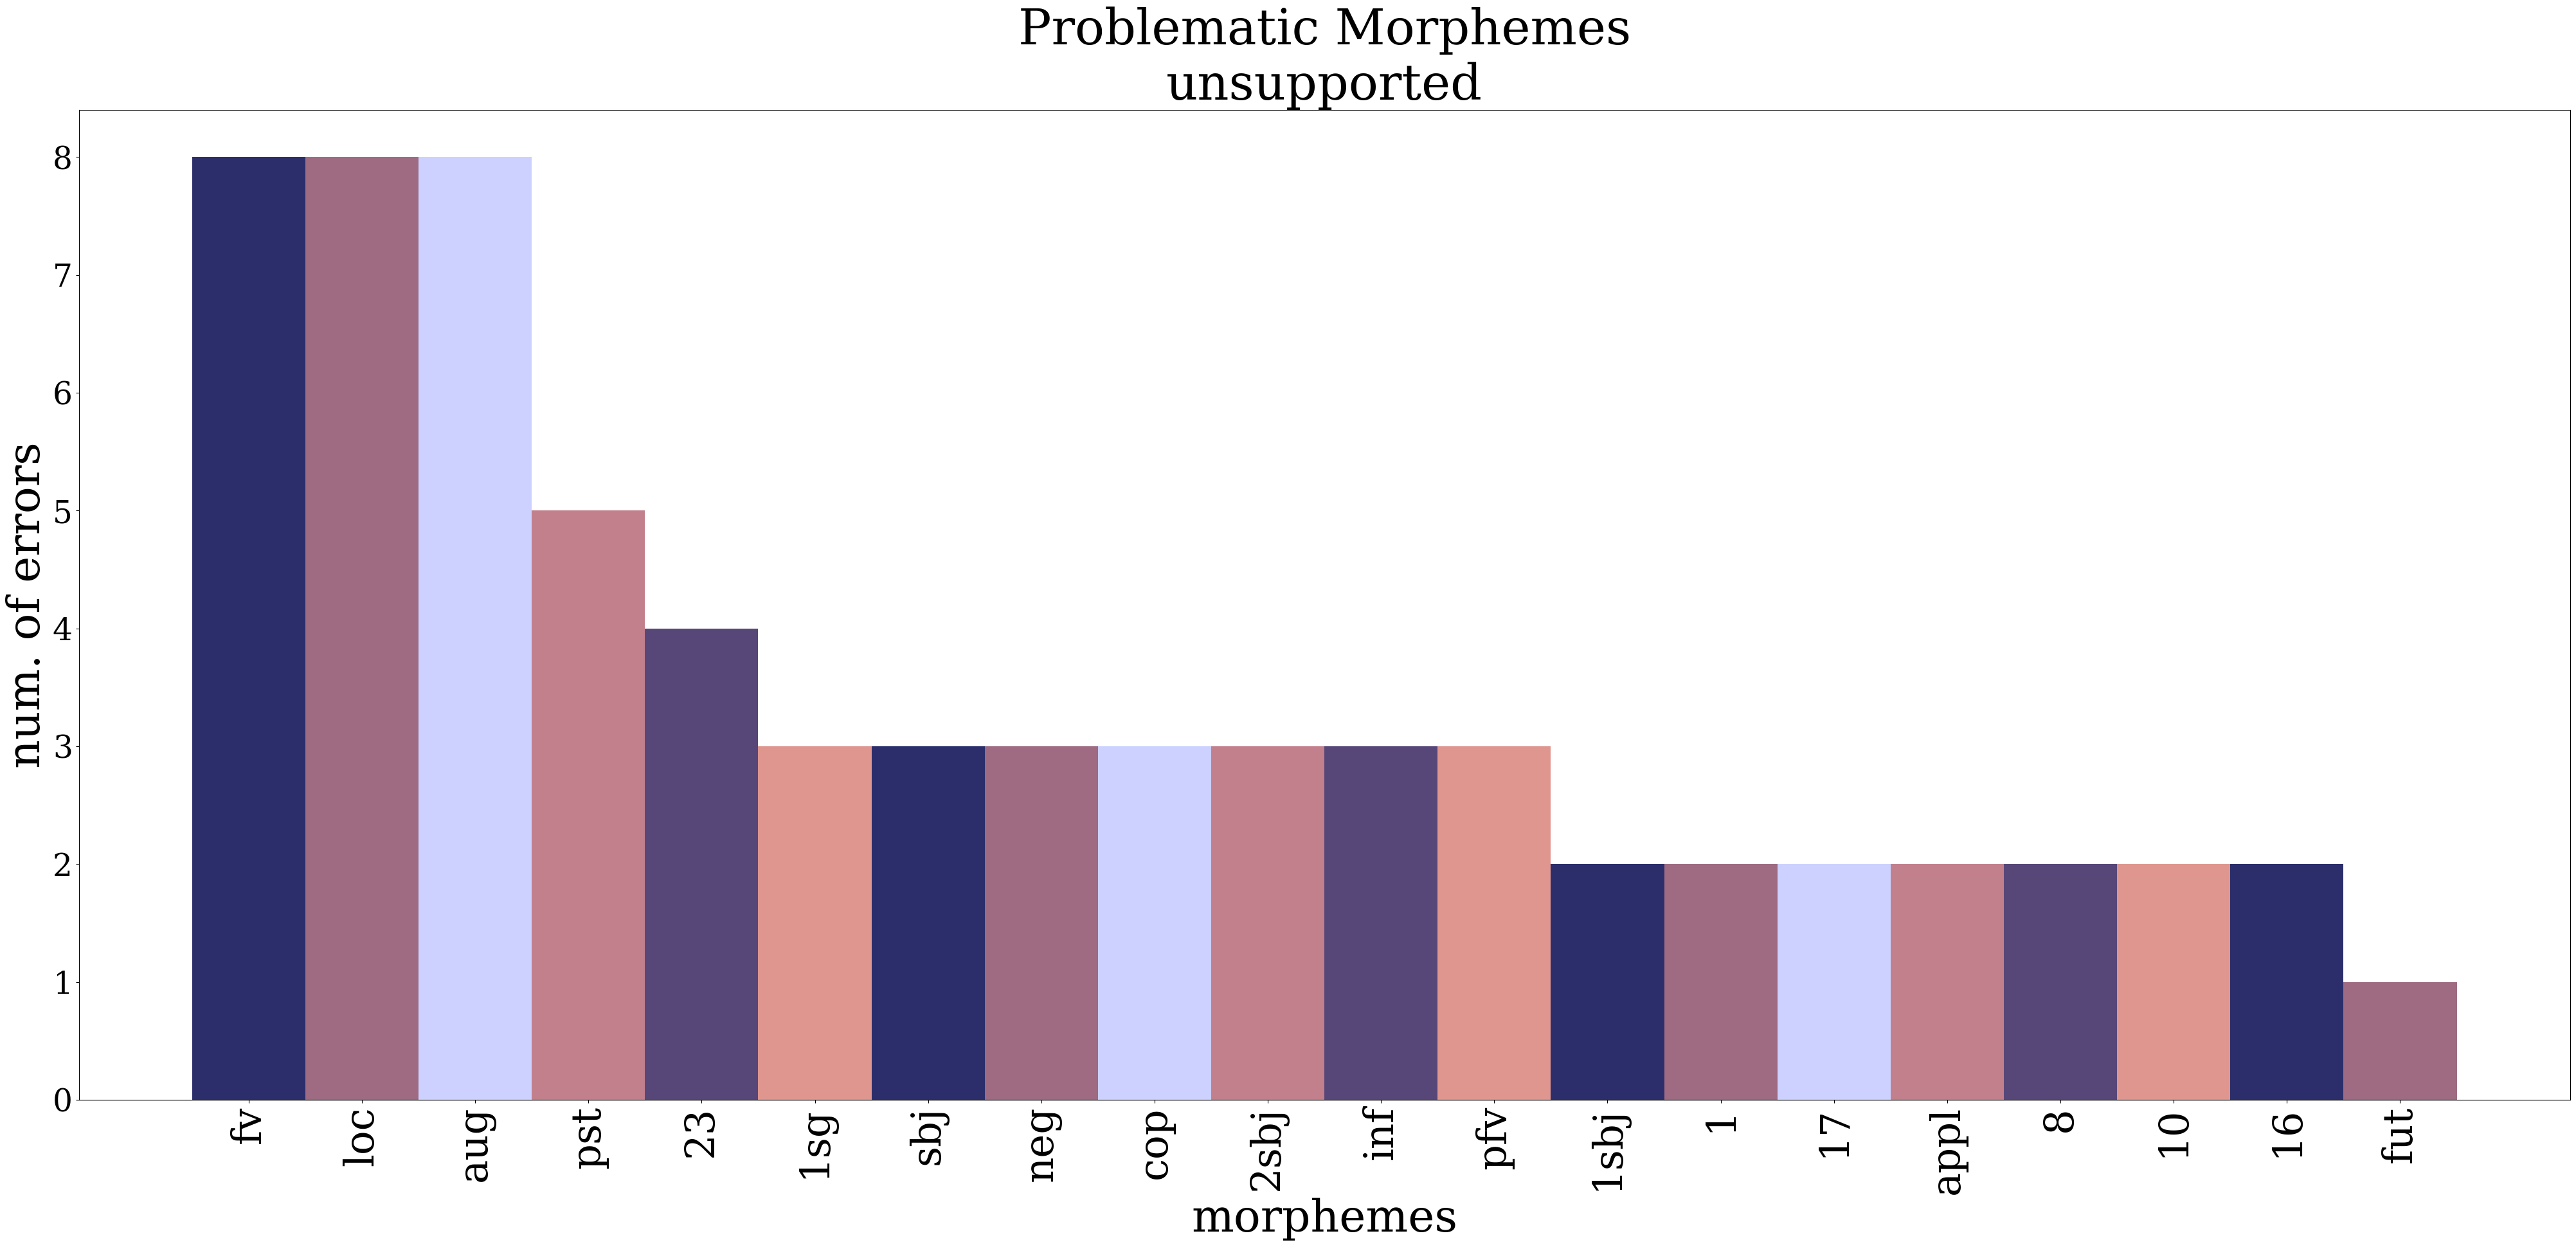

In [33]:
to_plot(err_dct['unsupported'], 'unsupported', limit=20)

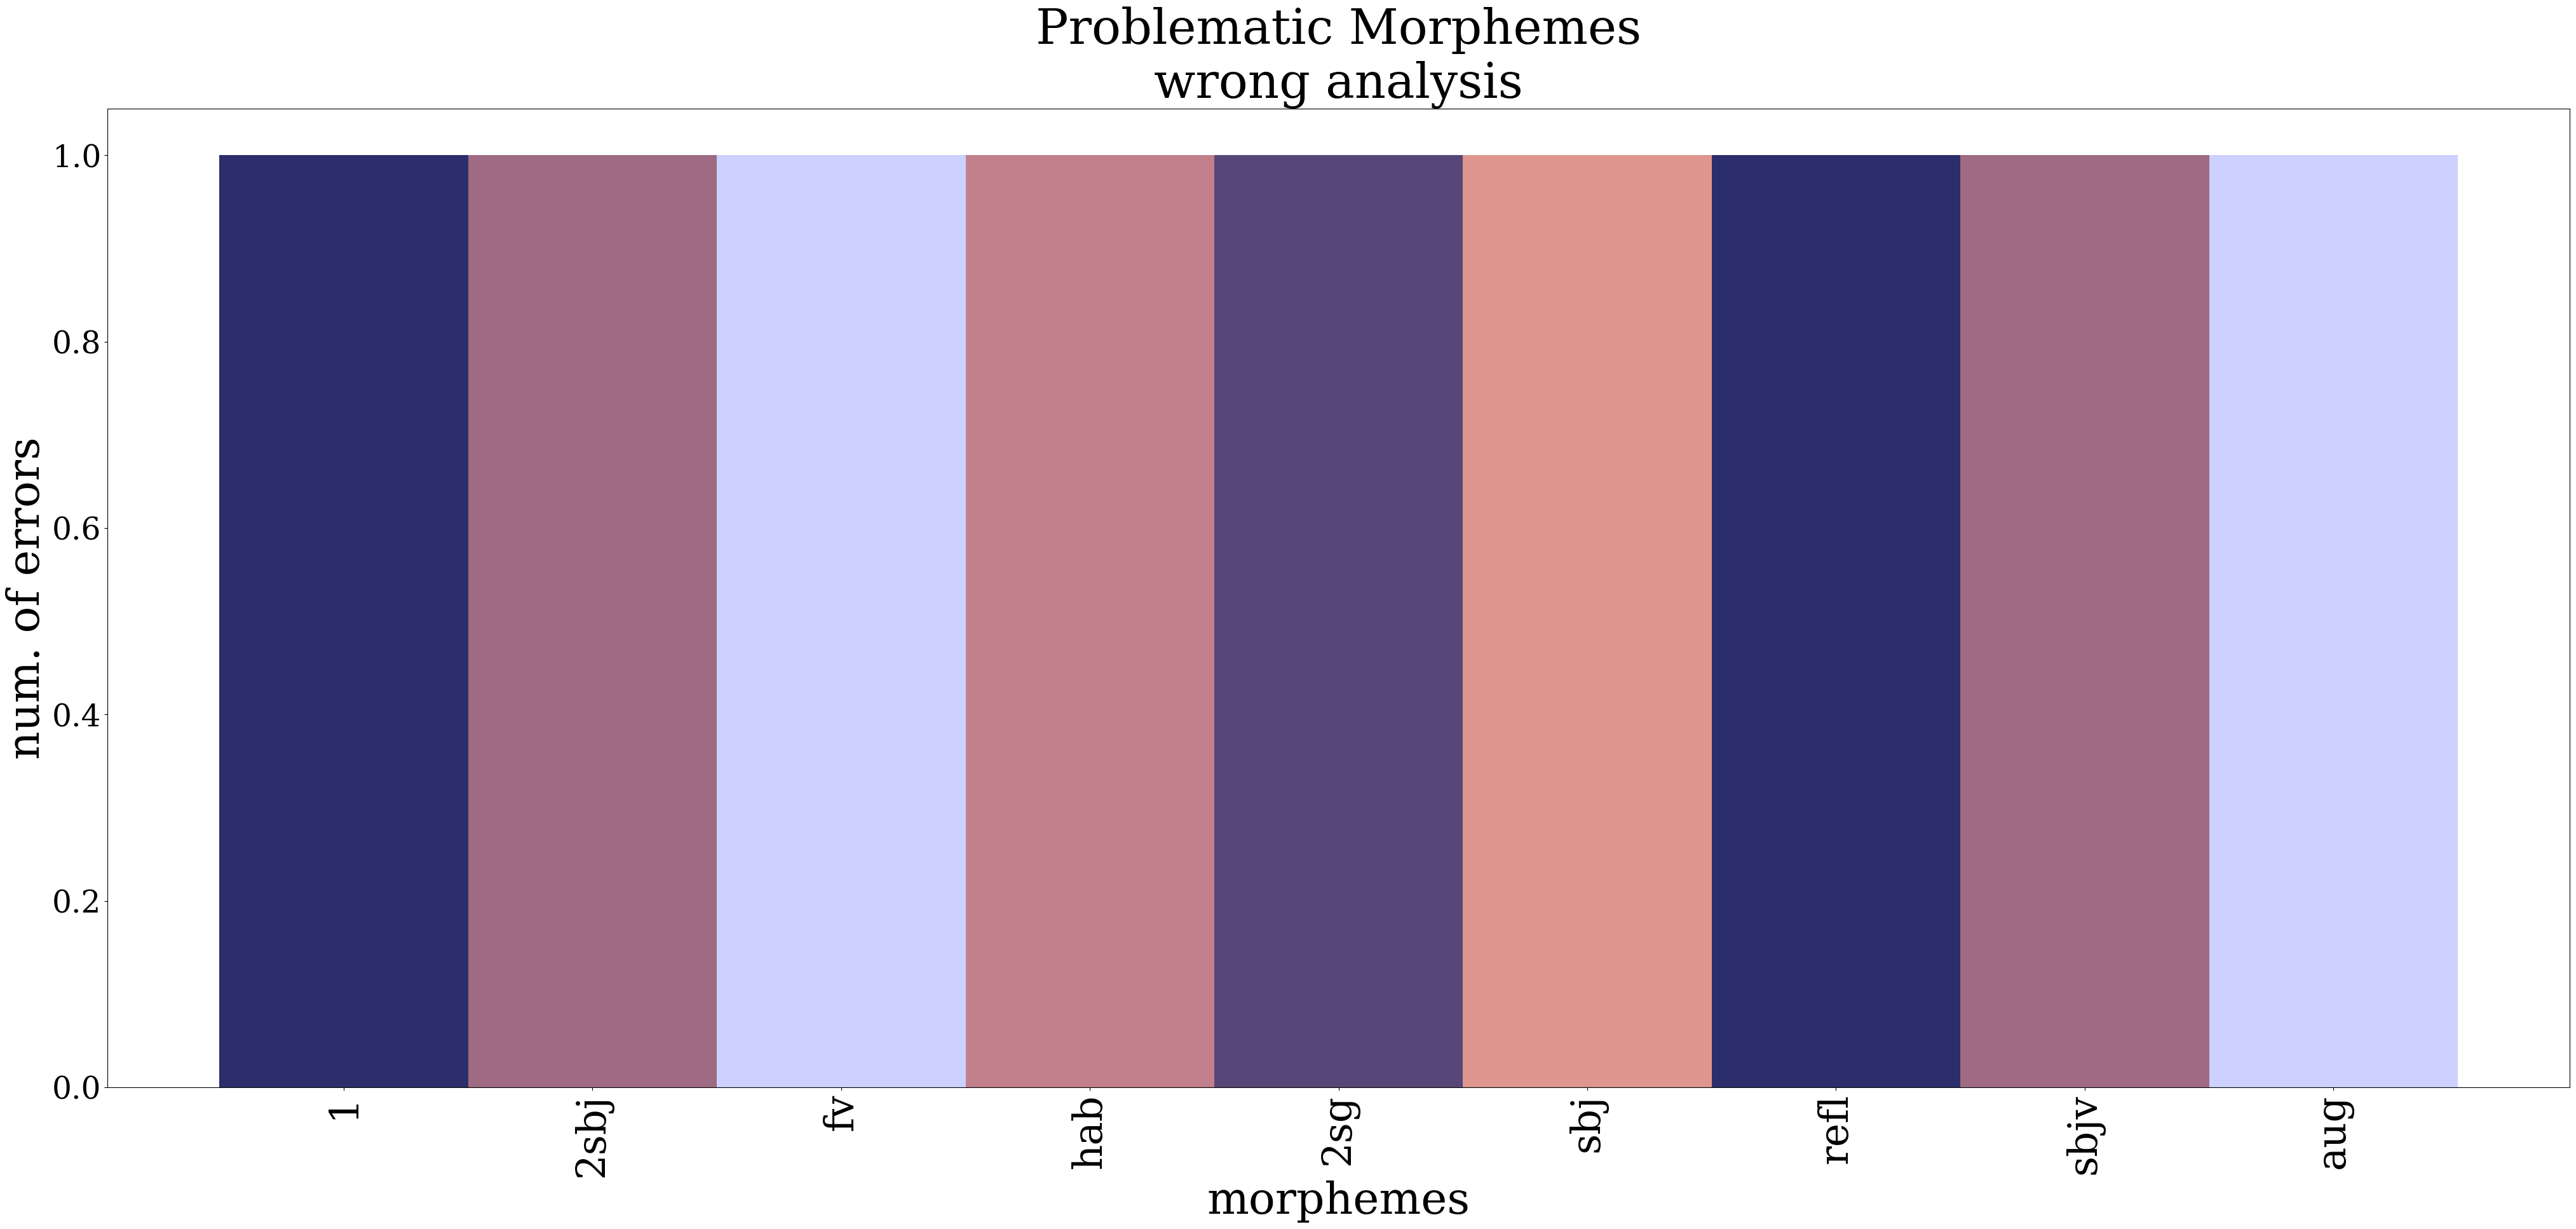

In [34]:
to_plot(err_dct['malanalysed'], 'wrong analysis')